<a href="https://colab.research.google.com/github/skarthi369/AI-AURA--HACKFINITY/blob/main/ageticwhether.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle==1.5.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73026 sha256=cc8e29e306e9717e3ac8a9de4f6da19de36db56aaf150ffa4121eba6fcc41190
  Stored in directory: /root/.cache/pip/wheels/2e/27/39/f44e52756a6407b444143f233abe9fda0e18a23e8b20e0cd1c
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls -l

total 8
-rw-r--r-- 1 root root   76 Mar 14 12:48 kaggle.json
drwxr-xr-x 1 root root 4096 Mar 12 13:35 sample_data


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dineshkumarvaids2226","key":"972a78d13d665b71bed31dd7ff5127e1"}'}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler




FileNotFoundError: [Errno 2] No such file or directory: '/content/weather-prediction-dataset/seattle-weather.csv'

In [ ]:
# Create the directory
!mkdir weather-prediction-dataset

# Upload the file into the directory
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  !mv "{fn}" "weather-prediction-dataset/{fn}"

Saving seattle-weather.csv to seattle-weather.csv


Saving seattle-weather.csv to seattle-weather.csv
Moving Average MAE: 2.58°C
KNN MAE: 2.01°C

Model Comparison:
         Model      MAE                Strengths                     Weaknesses
Moving Average 2.581080             Simple, fast       Ignores weather patterns
     KNN (K=3) 2.007717    Uses multiple factors      Slower for large datasets
  Markov Chain 3.960136 Models state transitions Oversimplifies continuous data


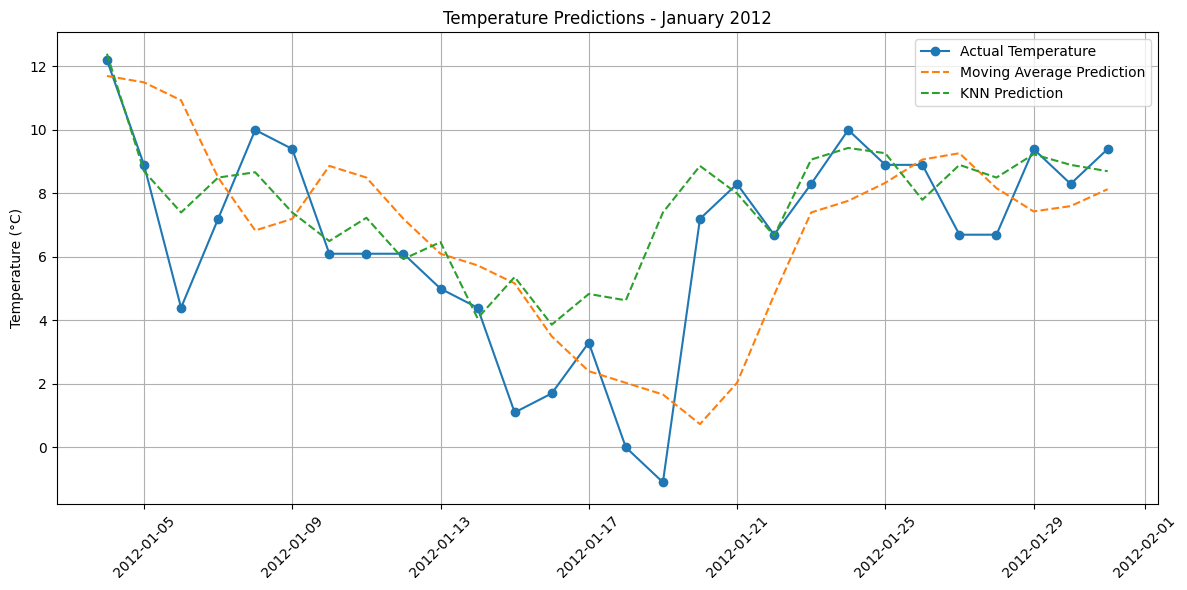

In [ ]:
# Install dependencies (if required)
!pip install scikit-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from google.colab import files

# Upload data
uploaded = files.upload()  # Upload 'seattle-weather.csv' via Colab's interface
df = pd.read_csv('seattle-weather.csv', parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)

# 1. Moving Average Model
df['ma_3day_pred'] = df['temp_max'].rolling(window=3).mean().shift(1)

# 2. KNN Model
df['target'] = df['temp_max'].shift(-1)  # Next day's temperature
df = df.dropna(subset=['target'])

# Select features and target
features = ['temp_max', 'precipitation', 'wind']
X = df[features]
y = df['target']

# Split data (chronological split)
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# Predictions
knn_pred_train = knn.predict(X_train_scaled)
knn_pred_test = knn.predict(X_test_scaled)

# Add predictions to dataframe
df.loc[X_train.index, 'knn_pred'] = knn_pred_train
df.loc[X_test.index, 'knn_pred'] = knn_pred_test

# Calculate MAE
valid_ma = df.dropna(subset=['ma_3day_pred'])
mae_ma = mean_absolute_error(valid_ma['temp_max'], valid_ma['ma_3day_pred'])

valid_knn = df.dropna(subset=['knn_pred'])
mae_knn = mean_absolute_error(valid_knn['target'], valid_knn['knn_pred'])

print(f"Moving Average MAE: {mae_ma:.2f}°C")
print(f"KNN MAE: {mae_knn:.2f}°C")

# Visualization for January 2012
jan_2012 = df[(df['date'] >= '2012-01-01') &
               (df['date'] <= '2012-01-31')].dropna(subset=['ma_3day_pred', 'knn_pred'])

# Markov Chain Implementation
n_states = 3  # Cold, Mild, Hot
df['state'] = pd.cut(df['temp_max'], bins=n_states, labels=[f'State_{i}' for i in range(n_states)])

# Create transition matrix
transition_counts = pd.crosstab(df['state'].shift(1), df['state'], dropna=False)
transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0).fillna(0)

# Predict next state
def predict_next_state(current_state):
    return transition_matrix.loc[current_state].idxmax()

# Generate predictions
df['markov_pred_state'] = df['state'].shift(1).apply(lambda x: predict_next_state(x) if pd.notnull(x) else np.nan)

# Convert state predictions back to temperatures (use bin midpoints)
bin_edges = pd.cut(df['temp_max'], bins=n_states, retbins=True)[1]
state_midpoints = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(n_states)]
state_to_temp = {f'State_{i}': state_midpoints[i] for i in range(n_states)}

df['markov_pred'] = df['markov_pred_state'].map(state_to_temp)

# Calculate MAE for Markov Chain
valid_markov = df.dropna(subset=['markov_pred'])
mae_markov = mean_absolute_error(valid_markov['temp_max'], valid_markov['markov_pred'])

# Results Table
results = pd.DataFrame({
    'Model': ['Moving Average', 'KNN (K=3)', 'Markov Chain'],
    'MAE': [mae_ma, mae_knn, mae_markov],
    'Strengths': ['Simple, fast', 'Uses multiple factors', 'Models state transitions'],
    'Weaknesses': ['Ignores weather patterns', 'Slower for large datasets', 'Oversimplifies continuous data']
})

print("\nModel Comparison:")
print(results.to_string(index=False))

# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(jan_2012['date'], jan_2012['temp_max'], label='Actual Temperature', marker='o')
plt.plot(jan_2012['date'], jan_2012['ma_3day_pred'], label='Moving Average Prediction', linestyle='--')
plt.plot(jan_2012['date'], jan_2012['knn_pred'], label='KNN Prediction', linestyle='--')
plt.title('Temperature Predictions - January 2012')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
